In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import string
import warnings
import spacy
from tqdm.notebook import tqdm_notebook

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [2]:
# Load the dataset
from google.colab import files
uploaded = files.upload()

Saving iphon14 reviews.csv to iphon14 reviews.csv


In [3]:
# Read dataset
reviews=pd.read_csv('iphon14 reviews.csv',encoding='Latin-1')
reviews

,Id,Profile Name,Review,Review date,Rating,Colour,Size
0,R3PO8G3B0O2PSS,Sharath,It is just a review from my side so that its g...,6 June 2023,3,Midnight,128 GB
1,R3QN7WHCT1NEQA,Prasanna,About the phoneApple phone without a second de...,22 June 2023,5,Red,128 GB
2,R162ZPIZIORMXV,manoj tomar,Very liked the phone,1 July 2023,4,Midnight,128 GB
3,RYJOV80T6QI8V,Anamitra Ghosh,Pros:1. Powerful A15 Bionic chip2. Beautiful O...,3 June 2023,4,Purple,128 GB
4,RB0BO4DEM77O4,Sam,"I prefer to have some privacy in life, I think...",27 June 2023,5,Midnight,128 GB
...,...,...,...,...,...,...,...
91,R1WWKFQRTC6HRD,manas parhi,Like the camer,15 May 2023,5,Midnight,128 GB
92,R9Y16VLX4KW79,Carthikeyan,Premium device worth the price.Great display e...,8 May 2023,5,Starlight,128 GB
93,R3PRKVCS3ZEZVH,Bittu,The best of all ipdone seriesProductivity is t...,7 May 2023,5,Blue,128 GB
94,R2ASICI54TPNQ6,abdulazeez,Good,12 May 2023,5,Midnight,128 GB


# Data Exploration

In [4]:
reviews.Rating.describe()

count    96.000000
mean      4.729167
std       0.532702
min       3.000000
25%       5.000000
50%       5.000000
75%       5.000000
max       5.000000
Name: Rating, dtype: float64

In [5]:
# Number of Words
reviews['word_count'] = reviews['Review'].apply(lambda x: len(str(x).split(" ")))
reviews[['Review','word_count']].head()

,Review,word_count
0,It is just a review from my side so that its g...,360
1,About the phoneApple phone without a second de...,429
2,Very liked the phone,4
3,Pros:1. Powerful A15 Bionic chip2. Beautiful O...,90
4,"I prefer to have some privacy in life, I think...",174


In [6]:
# Number of Characters
reviews['char_count'] = reviews['Review'].str.len() ## this also includes spaces
reviews[['Review','char_count']].head()

,Review,char_count
0,It is just a review from my side so that its g...,2001.0
1,About the phoneApple phone without a second de...,2397.0
2,Very liked the phone,20.0
3,Pros:1. Powerful A15 Bionic chip2. Beautiful O...,551.0
4,"I prefer to have some privacy in life, I think...",957.0


In [7]:
# Average Word Length
def avg_word(sentence):
  words = str(sentence).split()
  return (sum(len(word) for word in words)/len(words))

reviews['avg_word'] = reviews['Review'].apply(lambda x: avg_word(x))
reviews[['Review','avg_word']].head()

,Review,avg_word
0,It is just a review from my side so that its g...,4.561111
1,About the phoneApple phone without a second de...,4.600467
2,Very liked the phone,4.250000
3,Pros:1. Powerful A15 Bionic chip2. Beautiful O...,5.133333
4,"I prefer to have some privacy in life, I think...",4.505747


In [8]:
# Number of Stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

reviews['stopwords'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x in stop]))
reviews[['Review','stopwords']].head()

,Review,stopwords
0,It is just a review from my side so that its g...,135
1,About the phoneApple phone without a second de...,164
2,Very liked the phone,1
3,Pros:1. Powerful A15 Bionic chip2. Beautiful O...,29
4,"I prefer to have some privacy in life, I think...",59


In [9]:
# Number of Special Characters
reviews['hashtags'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x.startswith('#')]))
reviews[['Review','hashtags']].head()

,Review,hashtags
0,It is just a review from my side so that its g...,0
1,About the phoneApple phone without a second de...,0
2,Very liked the phone,0
3,Pros:1. Powerful A15 Bionic chip2. Beautiful O...,0
4,"I prefer to have some privacy in life, I think...",0


In [10]:
# Number of Numerics
reviews['numerics'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))
reviews[['Review','numerics']].head()

,Review,numerics
0,It is just a review from my side so that its g...,2
1,About the phoneApple phone without a second de...,10
2,Very liked the phone,0
3,Pros:1. Powerful A15 Bionic chip2. Beautiful O...,3
4,"I prefer to have some privacy in life, I think...",0


In [11]:
# Number of Uppercase Words
reviews['upper'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x.isupper()]))
reviews[['Review','upper']].head()

,Review,upper
0,It is just a review from my side so that its g...,3
1,About the phoneApple phone without a second de...,8
2,Very liked the phone,0
3,Pros:1. Powerful A15 Bionic chip2. Beautiful O...,3
4,"I prefer to have some privacy in life, I think...",12


In [12]:
reviews.drop(['numerics','hashtags','stopwords','avg_word','char_count','word_count','upper'],axis=1,inplace=True)


**Spelling correction**

We’ve all seen tweets with a plethora of spelling mistakes. Our timelines are often filled with hastly sent tweets that are barely legible at times.

In that regard, spelling correction is a useful pre-processing step because this also will help us in reducing multiple copies of words.

To achieve this we will use the textblob library. If you are not familiar with it, you can check my previous article on ‘NLP for beginners using textblob.

In [13]:
# Spelling correction
from textblob import TextBlob
reviews['Review'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    It is just a review from my side so that its g...
1    About the phoneApple phone without a second de...
2                                 Very liked the phone
3    Gros:1. Powerful A15 Ironic chip. Beautiful OL...
4    I prefer to have some privacy in life, I think...
Name: Review, dtype: object

# **Feature Engineering**

In [14]:
print(reviews['Review date'].str.split(' ').str[0],'\n',
      reviews['Review date'].str.split(' ').str[1],'\n',
      reviews['Review date'].str.split(' ').str[2])

0      6
1     22
2      1
3      3
4     27
      ..
91    15
92     8
93     7
94    12
95     1
Name: Review date, Length: 96, dtype: object 
 0     June
1     June
2     July
3     June
4     June
      ... 
91     May
92     May
93     May
94     May
95    July
Name: Review date, Length: 96, dtype: object 
 0     2023
1     2023
2     2023
3     2023
4     2023
      ... 
91    2023
92    2023
93    2023
94    2023
95    2023
Name: Review date, Length: 96, dtype: object


In [16]:
#Spliting Review Date into Three seperate Columns (Year,Month,Day)
df=reviews.copy()
df['Date']=df['Review date'].str.split(' ').str[0]
df['Month']=df['Review date'].str.split(' ').str[1]
df['Year']=df['Review date'].str.split(' ').str[2]
df[['Date','Month','Year']]

,Date,Month,Year
0,6,June,2023
1,22,June,2023
2,1,July,2023
3,3,June,2023
4,27,June,2023
...,...,...,...
91,15,May,2023
92,8,May,2023
93,7,May,2023
94,12,May,2023


In [17]:
df.Month.value_counts()

May      44
June     41
July      9
April     2
Name: Month, dtype: int64

In [18]:
# Change 'month' from words to numbers for easier analysis
order={'Month':{'March':3,'April':4,'May':5,'June':6,'July': 7}}
df1= df.copy()
df1=df1.replace(order)
df1[['Month']]

,Month
0,6
1,6
2,7
3,6
4,6
...,...
91,5
92,5
93,5
94,5


In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            96 non-null     object
 1   Profile Name  96 non-null     object
 2   Review        94 non-null     object
 3   Review date   96 non-null     object
 4   Rating        96 non-null     int64 
 5   Colour        96 non-null     object
 6   Size          96 non-null     object
 7   Date          96 non-null     object
 8   Month         96 non-null     int64 
 9   Year          96 non-null     object
dtypes: int64(2), object(8)
memory usage: 7.6+ KB


In [20]:
df1[['Date','Year']]=df1[['Date','Year']].astype('int64')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            96 non-null     object
 1   Profile Name  96 non-null     object
 2   Review        94 non-null     object
 3   Review date   96 non-null     object
 4   Rating        96 non-null     int64 
 5   Colour        96 non-null     object
 6   Size          96 non-null     object
 7   Date          96 non-null     int64 
 8   Month         96 non-null     int64 
 9   Year          96 non-null     int64 
dtypes: int64(4), object(6)
memory usage: 7.6+ KB


In [22]:
# Dropping the Original Columns after splitting the data
df1.drop('Review date',axis=1, inplace=True)
df1.head()

,Id,Profile Name,Review,Rating,Colour,Size,Date,Month,Year
0,R3PO8G3B0O2PSS,Sharath,It is just a review from my side so that its g...,3,Midnight,128 GB,6,6,2023
1,R3QN7WHCT1NEQA,Prasanna,About the phoneApple phone without a second de...,5,Red,128 GB,22,6,2023
2,R162ZPIZIORMXV,manoj tomar,Very liked the phone,4,Midnight,128 GB,1,7,2023
3,RYJOV80T6QI8V,Anamitra Ghosh,Pros:1. Powerful A15 Bionic chip2. Beautiful O...,4,Purple,128 GB,3,6,2023
4,RB0BO4DEM77O4,Sam,"I prefer to have some privacy in life, I think...",5,Midnight,128 GB,27,6,2023


In [23]:
df

,Id,Profile Name,Review,Review date,Rating,Colour,Size,Date,Month,Year
0,R3PO8G3B0O2PSS,Sharath,It is just a review from my side so that its g...,6 June 2023,3,Midnight,128 GB,6,June,2023
1,R3QN7WHCT1NEQA,Prasanna,About the phoneApple phone without a second de...,22 June 2023,5,Red,128 GB,22,June,2023
2,R162ZPIZIORMXV,manoj tomar,Very liked the phone,1 July 2023,4,Midnight,128 GB,1,July,2023
3,RYJOV80T6QI8V,Anamitra Ghosh,Pros:1. Powerful A15 Bionic chip2. Beautiful O...,3 June 2023,4,Purple,128 GB,3,June,2023
4,RB0BO4DEM77O4,Sam,"I prefer to have some privacy in life, I think...",27 June 2023,5,Midnight,128 GB,27,June,2023
...,...,...,...,...,...,...,...,...,...,...
91,R1WWKFQRTC6HRD,manas parhi,Like the camer,15 May 2023,5,Midnight,128 GB,15,May,2023
92,R9Y16VLX4KW79,Carthikeyan,Premium device worth the price.Great display e...,8 May 2023,5,Starlight,128 GB,8,May,2023
93,R3PRKVCS3ZEZVH,Bittu,The best of all ipdone seriesProductivity is t...,7 May 2023,5,Blue,128 GB,7,May,2023
94,R2ASICI54TPNQ6,abdulazeez,Good,12 May 2023,5,Midnight,128 GB,12,May,2023


# **Data Visualization**

date versus review count

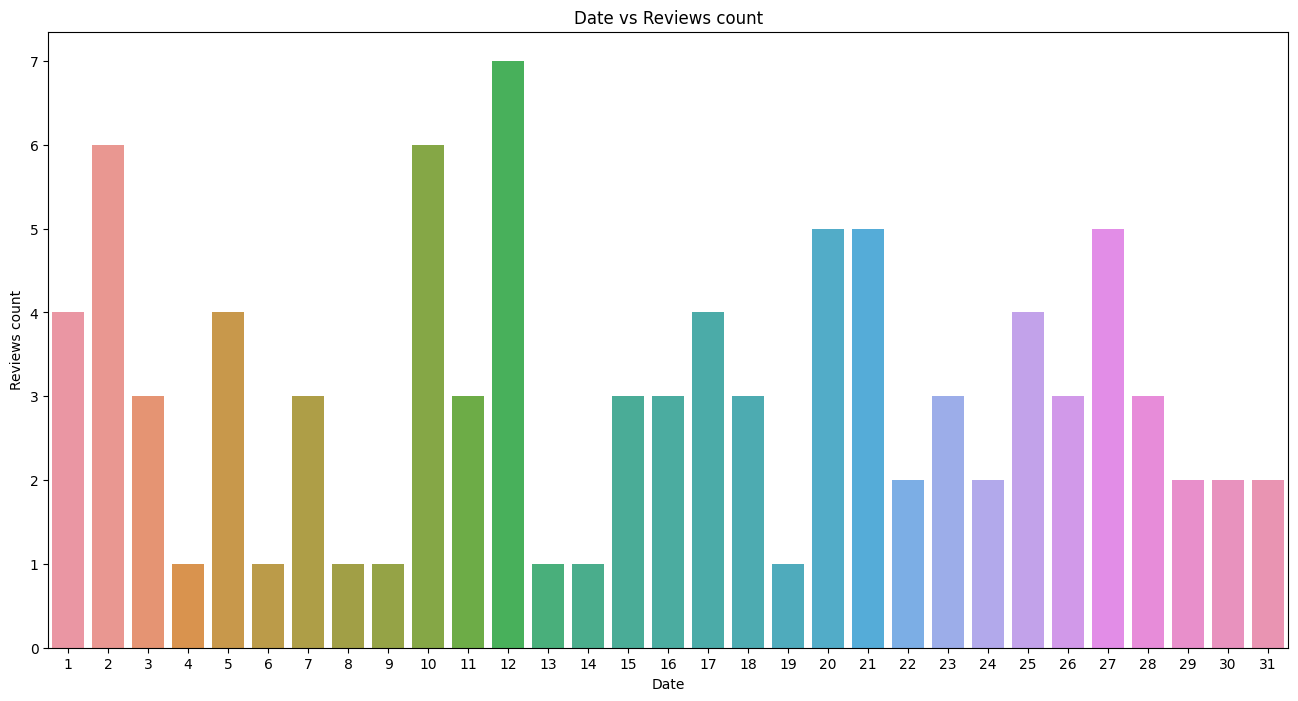

In [24]:
#Creating a dataframe
dayreview = pd.DataFrame(df.groupby('Date')['Review'].count()).reset_index()
dayreview['Date'] = dayreview['Date'].astype('int64')
dayreview.sort_values(by = ['Date'])

#Plotting the graph
plt.figure(figsize=(16,8))
sns.barplot(x = "Date", y = "Review", data = dayreview)
plt.title('Date vs Reviews count')
plt.xlabel('Date')
plt.ylabel('Reviews count')
plt.show()

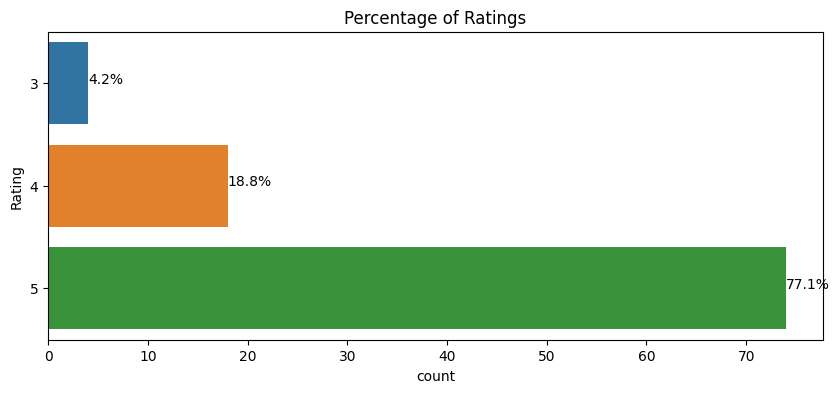

In [27]:
plt.figure(figsize=(10,4))
plt.title('Percentage of Ratings')
ax = sns.countplot(y = 'Rating', data = reviews)
total = len(reviews)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

# **BasicText Preprocessing**

Sentiment Analysis

In [54]:
data = df[['Review']]
data

,Review
0,It is just a review from my side so that its g...
1,About the phoneApple phone without a second de...
2,Very liked the phone
3,Pros:1. Powerful A15 Bionic chip2. Beautiful O...
4,"I prefer to have some privacy in life, I think..."
...,...
91,Like the camer
92,Premium device worth the price.Great display e...
93,The best of all ipdone seriesProductivity is t...
94,Good


In [55]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
data['Review'] = data['Review'].apply(lambda x: " ".join(x.lower() for x in str(x).split() \
                                    if x not in stop_words))

In [56]:
data

,Review
0,it review side good know buying rather regrett...
1,"about phoneapple phone without second delay, i..."
2,very liked phone
3,pros:1. powerful a15 bionic chip2. beautiful o...
4,"i prefer privacy life, i think apple suite bit..."
...,...
91,like camer
92,premium device worth price.great display excel...
93,the best ipdone seriesproductivity good
94,good


In [57]:
lemmatizer = WordNetLemmatizer()

# Removing punctuation, making str to lower, applying Lemmatizer, Removing Stop words
corpus=[]
for i in tqdm_notebook(range(0, len(data))):
    cleaned= re.sub('[^a-zA-Z]', " ", data["Review"][i])
    cleaned= cleaned.lower()
    cleaned = cleaned.split()
    cleaned= [lemmatizer.lemmatize(word) for word in cleaned if word not in stopwords.words("english")]
    cleaned= ' '.join(cleaned)
    corpus.append(cleaned)

  0%|          | 0/96 [00:00<?, ?it/s]

In [58]:
#Saving cleaned data to compare with original data, to ckeck amount of information lost
dataframe = pd.DataFrame({"Clean_Reviews": corpus,"Uncleaned_Reviews": df.Review})
dataframe.head()

,Clean_Reviews,Uncleaned_Reviews
0,review side good know buying rather regretting...,It is just a review from my side so that its g...
1,phoneapple phone without second delay would sa...,About the phoneApple phone without a second de...
2,liked phone,Very liked the phone
3,pro powerful bionic chip beautiful oled displa...,Pros:1. Powerful A15 Bionic chip2. Beautiful O...
4,prefer privacy life think apple suite bit priv...,"I prefer to have some privacy in life, I think..."


# **Text Pre-processing Techniques**

 Pre-processing 'Key Words'

In [59]:
#  Removing '@names'
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)

    return text

In [60]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
dataframe['Clean_Reviews'] = np.vectorize(remove_pattern)(dataframe['Clean_Reviews'], "@[\w]*")
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,review side good know buying rather regretting...,It is just a review from my side so that its g...
1,phoneapple phone without second delay would sa...,About the phoneApple phone without a second de...
2,liked phone,Very liked the phone
3,pro powerful bionic chip beautiful oled displa...,Pros:1. Powerful A15 Bionic chip2. Beautiful O...
4,prefer privacy life think apple suite bit priv...,"I prefer to have some privacy in life, I think..."
5,upgraded iphone iphone simple iphone best way ...,I upgraded from iPhone 11 to iPhone 14. In sim...
6,good low end use,Good @ low end use
7,product good always time delivery also satisfying,"Product is good as always, but this time deliv..."
8,good product,What good product
9,trust worthygo first time buyer scared amazon ...,Itâs trusts worthyGo for it as a first time ...


In [61]:
# Removing links (http | https)
cleaned_reviews = []

for index, row in dataframe.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Clean_Reviews.split() if 'http' not in word]
    cleaned_reviews.append(' '.join(words_without_links))

dataframe['Clean_Reviews'] = cleaned_reviews
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,review side good know buying rather regretting...,It is just a review from my side so that its g...
1,phoneapple phone without second delay would sa...,About the phoneApple phone without a second de...
2,liked phone,Very liked the phone
3,pro powerful bionic chip beautiful oled displa...,Pros:1. Powerful A15 Bionic chip2. Beautiful O...
4,prefer privacy life think apple suite bit priv...,"I prefer to have some privacy in life, I think..."
5,upgraded iphone iphone simple iphone best way ...,I upgraded from iPhone 11 to iPhone 14. In sim...
6,good low end use,Good @ low end use
7,product good always time delivery also satisfying,"Product is good as always, but this time deliv..."
8,good product,What good product
9,trust worthygo first time buyer scared amazon ...,Itâs trusts worthyGo for it as a first time ...


In [62]:
# Removing Review with empty text
dataframe = dataframe[dataframe['Clean_Reviews']!='']
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,review side good know buying rather regretting...,It is just a review from my side so that its g...
1,phoneapple phone without second delay would sa...,About the phoneApple phone without a second de...
2,liked phone,Very liked the phone
3,pro powerful bionic chip beautiful oled displa...,Pros:1. Powerful A15 Bionic chip2. Beautiful O...
4,prefer privacy life think apple suite bit priv...,"I prefer to have some privacy in life, I think..."
5,upgraded iphone iphone simple iphone best way ...,I upgraded from iPhone 11 to iPhone 14. In sim...
6,good low end use,Good @ low end use
7,product good always time delivery also satisfying,"Product is good as always, but this time deliv..."
8,good product,What good product
9,trust worthygo first time buyer scared amazon ...,Itâs trusts worthyGo for it as a first time ...


In [63]:
# Dropping duplicate rows
dataframe.drop_duplicates(subset=['Clean_Reviews'], keep=False)
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,review side good know buying rather regretting...,It is just a review from my side so that its g...
1,phoneapple phone without second delay would sa...,About the phoneApple phone without a second de...
2,liked phone,Very liked the phone
3,pro powerful bionic chip beautiful oled displa...,Pros:1. Powerful A15 Bionic chip2. Beautiful O...
4,prefer privacy life think apple suite bit priv...,"I prefer to have some privacy in life, I think..."
5,upgraded iphone iphone simple iphone best way ...,I upgraded from iPhone 11 to iPhone 14. In sim...
6,good low end use,Good @ low end use
7,product good always time delivery also satisfying,"Product is good as always, but this time deliv..."
8,good product,What good product
9,trust worthygo first time buyer scared amazon ...,Itâs trusts worthyGo for it as a first time ...


In [64]:
# Resetting index
dataframe = dataframe.reset_index(drop=True)
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,review side good know buying rather regretting...,It is just a review from my side so that its g...
1,phoneapple phone without second delay would sa...,About the phoneApple phone without a second de...
2,liked phone,Very liked the phone
3,pro powerful bionic chip beautiful oled displa...,Pros:1. Powerful A15 Bionic chip2. Beautiful O...
4,prefer privacy life think apple suite bit priv...,"I prefer to have some privacy in life, I think..."
5,upgraded iphone iphone simple iphone best way ...,I upgraded from iPhone 11 to iPhone 14. In sim...
6,good low end use,Good @ low end use
7,product good always time delivery also satisfying,"Product is good as always, but this time deliv..."
8,good product,What good product
9,trust worthygo first time buyer scared amazon ...,Itâs trusts worthyGo for it as a first time ...


In [65]:
# Removing Punctuations, Numbers and Special characters
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [66]:
dataframe['Clean_Reviews'] = dataframe['Clean_Reviews'].apply(lambda x: clean_text(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,review side good know buying rather regretting...,It is just a review from my side so that its g...
1,phoneapple phone without second delay would sa...,About the phoneApple phone without a second de...
2,liked phone,Very liked the phone
3,pro powerful bionic chip beautiful oled displa...,Pros:1. Powerful A15 Bionic chip2. Beautiful O...
4,prefer privacy life think apple suite bit priv...,"I prefer to have some privacy in life, I think..."
5,upgraded iphone iphone simple iphone best way ...,I upgraded from iPhone 11 to iPhone 14. In sim...
6,good low end use,Good @ low end use
7,product good always time delivery also satisfying,"Product is good as always, but this time deliv..."
8,good product,What good product
9,trust worthygo first time buyer scared amazon ...,Itâs trusts worthyGo for it as a first time ...


In [67]:
# Function to remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [68]:
dataframe['Clean_Reviews']=dataframe['Clean_Reviews'].apply(lambda x: remove_emoji(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,review side good know buying rather regretting...,It is just a review from my side so that its g...
1,phoneapple phone without second delay would sa...,About the phoneApple phone without a second de...
2,liked phone,Very liked the phone
3,pro powerful bionic chip beautiful oled displa...,Pros:1. Powerful A15 Bionic chip2. Beautiful O...
4,prefer privacy life think apple suite bit priv...,"I prefer to have some privacy in life, I think..."
5,upgraded iphone iphone simple iphone best way ...,I upgraded from iPhone 11 to iPhone 14. In sim...
6,good low end use,Good @ low end use
7,product good always time delivery also satisfying,"Product is good as always, but this time deliv..."
8,good product,What good product
9,trust worthygo first time buyer scared amazon ...,Itâs trusts worthyGo for it as a first time ...


In [69]:
dataframe['tokenized_tweets'] = dataframe['Clean_Reviews'].apply(lambda x: nltk.word_tokenize(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews,tokenized_tweets
0,review side good know buying rather regretting...,It is just a review from my side so that its g...,"[review, side, good, know, buying, rather, reg..."
1,phoneapple phone without second delay would sa...,About the phoneApple phone without a second de...,"[phoneapple, phone, without, second, delay, wo..."
2,liked phone,Very liked the phone,"[liked, phone]"
3,pro powerful bionic chip beautiful oled displa...,Pros:1. Powerful A15 Bionic chip2. Beautiful O...,"[pro, powerful, bionic, chip, beautiful, oled,..."
4,prefer privacy life think apple suite bit priv...,"I prefer to have some privacy in life, I think...","[prefer, privacy, life, think, apple, suite, b..."
5,upgraded iphone iphone simple iphone best way ...,I upgraded from iPhone 11 to iPhone 14. In sim...,"[upgraded, iphone, iphone, simple, iphone, bes..."
6,good low end use,Good @ low end use,"[good, low, end, use]"
7,product good always time delivery also satisfying,"Product is good as always, but this time deliv...","[product, good, always, time, delivery, also, ..."
8,good product,What good product,"[good, product]"
9,trust worthygo first time buyer scared amazon ...,Itâs trusts worthyGo for it as a first time ...,"[trust, worthygo, first, time, buyer, scared, ..."


In [70]:
dataframe.drop(['tokenized_tweets'],axis=1,inplace=True)

In [76]:
import pandas as pd
import io

In [71]:
from google.colab import files
uploaded = files.upload()

Saving stop.txt to stop.txt


In [85]:
# Removing Stop words
stop = pd.read_csv(io.StringIO(uploaded["stop.txt"].decode("ISO-8859-1")))
print(stop)

              a
0           a's
1          able
2         about
3         above
4     according
..          ...
565       yours
566    yourself
567  yourselves
568           z
569        zero

[570 rows x 1 columns]


In [87]:
print(stop[:101])

                a
0             a's
1            able
2           about
3           above
4       according
..            ...
96   consequently
97       consider
98    considering
99        contain
100    containing

[101 rows x 1 columns]


In [95]:
TextBlob(dataframe['Clean_Reviews'][1]).words

WordList(['phoneapple', 'phone', 'without', 'second', 'delay', 'would', 'say', 'better', 'android', 'phone', 'used', 'phone', 'like', 'water', 'flow', 'way', 'want', 'shaping', 'way', 'best', 'way', 'possible', 'phone', 'designed', 'show', 'user', 'want', 'eliminating', 'unnecessary', 'ad', 'feature', 'seen', 'android', 'better', 'android', 'pay', 'much', 'money', 'apple', 'product', 'obviously', 'experience', 'feature', 'physical', 'component', 'camera', 'lens', 'etc', 'apart', 'basic', 'thing', 'also', 'enjoy', 'best', 'application', 'available', 'app', 'store', 'developer', 'might', 'know', 'app', 'store', 'policy', 'application', 'publish', 'security', 'posture', 'towards', 'handling', 'payment', 'apps', 'etc', 'publish', 'best', 'application', 'way', 'apps', 'module', 'switch', 'flawless', 'due', 'called', 'strict', 'policy', 'privacy', 'program', 'apple', 'product', 'iphone', 'pop', 'box', 'screen', 'apps', 'want', 'track', 'activity', 'application', 'respect', 'apple', 'show', '

In [96]:
tokenized_review = dataframe['Clean_Reviews'].apply(lambda x: x.split())
tokenized_review.head(10)

0    [review, side, good, know, buying, rather, reg...
1    [phoneapple, phone, without, second, delay, wo...
2                                       [liked, phone]
3    [pro, powerful, bionic, chip, beautiful, oled,...
4    [prefer, privacy, life, think, apple, suite, b...
5    [upgraded, iphone, iphone, simple, iphone, bes...
6                                [good, low, end, use]
7    [product, good, always, time, delivery, also, ...
8                                      [good, product]
9    [trust, worthygo, first, time, buyer, scared, ...
Name: Clean_Reviews, dtype: object

In [97]:
from nltk.stem.snowball import SnowballStemmer

# Use English stemmer.
stemmer = SnowballStemmer("english")

In [98]:
xx = pd.DataFrame()
xx['stemmed'] = dataframe['Clean_Reviews'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
xx

,stemmed
0,review side good know buy rather regret later ...
1,phoneappl phone without second delay would say...
2,like phone
3,pro power bionic chip beauti ole display excel...
4,prefer privaci life think appl suit bit privat...
...,...
91,like camer
92,premium devic worth price great display excel ...
93,best ipdon seriesproduct good
94,good


In [99]:
word_lemmatizer = WordNetLemmatizer()
nltk.download('omw-1.4')
yy=pd.DataFrame()
yy['stemmed'] = dataframe['Clean_Reviews'].apply(lambda x: " ".join([word_lemmatizer.lemmatize(i) for i in x.split()]))
yy

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,stemmed
0,review side good know buying rather regretting...
1,phoneapple phone without second delay would sa...
2,liked phone
3,pro powerful bionic chip beautiful oled displa...
4,prefer privacy life think apple suite bit priv...
...,...
91,like camer
92,premium device worth price great display excel...
93,best ipdone seriesproductivity good
94,good


# **Basic Feature Extaction**

Applying bag of Words without N grams

In [100]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
tweetscv=cv.fit_transform(dataframe.Clean_Reviews)

In [102]:
# Print(cv.vocabulary_)
print(cv.get_feature_names_out()[109:200])

['chipset' 'choosing' 'cinematic' 'claiming' 'class' 'classy' 'clean'
 'clear' 'clours' 'color' 'colour' 'come' 'coming' 'comparison'
 'complaint' 'complete' 'component' 'concern' 'condition' 'cone'
 'consider' 'consistency' 'consistent' 'consumer' 'contact' 'convenient'
 'cool' 'copy' 'corner' 'cost' 'costly' 'could' 'country' 'couple' 'coz'
 'crash' 'creative' 'current' 'customer' 'daily' 'damaged' 'data' 'day'
 'deal' 'debated' 'decent' 'default' 'delay' 'delivered' 'delivers'
 'delivery' 'dented' 'design' 'designed' 'detected' 'developer' 'device'
 'didi' 'difference' 'different' 'disappointed' 'disconnect' 'display'
 'double' 'draining' 'dream' 'driver' 'due' 'early' 'earphone' 'easier'
 'easily' 'edition' 'effect' 'efficient' 'either' 'ek' 'elegant'
 'eliminating' 'end' 'enjoy' 'enough' 'environment' 'error' 'especially'
 'essentially' 'etc' 'even' 'ever' 'every' 'everybody']


In [103]:
print(cv.get_feature_names_out()[:100])

['aacha' 'aagiya' 'able' 'absolutely' 'acceptable' 'accessibility'
 'activity' 'actually' 'ad' 'adapter' 'add' 'added' 'addicted' 'addition'
 'additional' 'adjustment' 'afford' 'ahead' 'airpods' 'already' 'also'
 'although' 'always' 'amazing' 'amazon' 'among' 'ample' 'android'
 'another' 'apart' 'app' 'appario' 'appealing' 'appearance' 'apple'
 'application' 'apps' 'arounds' 'ashamed' 'audio' 'authentication'
 'available' 'average' 'avoided' 'awesome' 'awesomecamera' 'ba' 'baat'
 'baba' 'back' 'background' 'bag' 'base' 'based' 'basic' 'battery' 'bear'
 'beautiful' 'become' 'beforehand' 'beginning' 'believe' 'best'
 'betraying' 'better' 'bigger' 'bionic' 'bit' 'black' 'bloat' 'block'
 'blue' 'bought' 'box' 'brand' 'brandbut' 'breaking' 'browsing' 'bt' 'bug'
 'business' 'button' 'buy' 'buyer' 'buying' 'cal' 'call' 'called' 'calm'
 'camer' 'camera' 'cannot' 'capacity' 'carbon' 'card' 'care' 'careful'
 'carton' 'case' 'category']


In [104]:
print(tweetscv.toarray()[100:200])

[]


CountVectorizer with N-grams (Bigrams & Trigrams)

In [105]:
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):
    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/96 [00:00<?, ?it/s]

In [106]:
corpus[3]

'pro power bionic chip beauti ole display excel camera qualiti long last batteri life secur face id authent year softwar updatescon expens major design chang iphon headphon jack expand storageoveral iphon great phone major upgrad iphon look new iphon iphon good option may want consid wait iphon expect signific chang'

In [107]:
## Applying Countvectorizer
# Creating the Bag of Words model
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [108]:
X.shape

(96, 3086)

In [109]:
cv.get_feature_names_out()[:20]

array(['aacha', 'aacha sai', 'aacha sai pack', 'aagiya', 'aagiya ba',
       'aagiya ba ek', 'abl', 'abl find', 'abl find call',
       'abl find default', 'absolut', 'absolut box',
       'absolut box although', 'accept', 'accept amazon',
       'accept amazon need', 'access', 'access first', 'access first day',
       'access option'], dtype=object)

In [110]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [112]:
count_df = pd.DataFrame(X, columns=cv.get_feature_names_out())
count_df

,aacha,aacha sai,aacha sai pack,aagiya,aagiya ba,aagiya ba ek,abl,abl find,abl find call,abl find default,...,yellow colour awesom,yoh,yoh search,yoh search iphon,youtub,youtub didi,youtub didi find,yr,yr want,yr want tri
0,0,0,0,0,0,0,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


TF-IDF Vectorizer

In [113]:
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):
    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/96 [00:00<?, ?it/s]

In [114]:
corpus[4]

'prefer privaci life think appl suit bit privat googl respect user privaci use third parti app option stock android without googl someth like lineageo iphon tri lineageo alway someth break phone becom daili driver wish thing android open sourc like map proprietari googl app current state left choos iphon long debat buy iphon use oneplu last year phone stop get updat mani bug softwar chang lot hate oem betray consum made switch iphon end trust brand consist like appl take phone market wish consist bloat free android brand great camera'

In [115]:
## TFidf Vectorizer
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=tfidf_v.fit_transform(corpus).toarray()

In [116]:
X.shape

(96, 3086)

In [117]:
tfidf_v.get_feature_names_out()[:20]

array(['aacha', 'aacha sai', 'aacha sai pack', 'aagiya', 'aagiya ba',
       'aagiya ba ek', 'abl', 'abl find', 'abl find call',
       'abl find default', 'absolut', 'absolut box',
       'absolut box although', 'accept', 'accept amazon',
       'accept amazon need', 'access', 'access first', 'access first day',
       'access option'], dtype=object)

In [118]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [119]:
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names_out())
count_df

,aacha,aacha sai,aacha sai pack,aagiya,aagiya ba,aagiya ba ek,abl,abl find,abl find call,abl find default,...,yellow colour awesom,yoh,yoh search,yoh search iphon,youtub,youtub didi,youtub didi find,yr,yr want,yr want tri
0,0.0,0.0,0.0,0.0,0.0,0.0,0.075083,0.075083,0.037542,0.037542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 Named Entity Recognition (NER)

In [120]:
reviews=[review.strip() for review in dataframe.Clean_Reviews] # remove both the leading and the trailing characters
reviews=[comment for comment in reviews if comment] # removes empty strings, because they are considered in Python as False
# Joining the list into one string/text
reviews_text=' '.join(reviews)
reviews_text[0:1000]

'review side good know buying rather regretting later positive showoff camera sound security say bt block many accessibility option many awesome feature iphone user say probably use lifetime negative may like shortcut change vibration vibration frequently end cal button lock screen call list nonsense show phone watsap call list goto specific contact call history n see history one day total length call history probably able find call history previous month specific contact need itunes copy music pc phone file manager like android see complete folder structure silent vibrate mode notification screen need buy separate adapter n earphone already spending double cannot remove torch icon iphone frm lock screen may end switching unwillingly bt wifi shortcut disconnect turn need go setting screen turn many place either text file select option take lot time get detected device hotspot screen get stuck miss back button copy mp file iphone never able find default music app every app either lot ho

In [121]:
# Parts Of Speech (POS) Tagging
nlp=spacy.load('en_core_web_sm')

one_block=reviews_text[:1000]
doc_block=nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)

In [122]:
for token in doc_block[:50]:
    print(token,token.pos_)

review VERB
side NOUN
good ADJ
know NOUN
buying VERB
rather ADV
regretting VERB
later ADV
positive ADJ
showoff NOUN
camera NOUN
sound NOUN
security NOUN
say VERB
bt ADJ
block VERB
many ADJ
accessibility NOUN
option NOUN
many ADJ
awesome ADJ
feature NOUN
iphone PROPN
user NOUN
say VERB
probably ADV
use VERB
lifetime NOUN
negative ADJ
may AUX
like VERB
shortcut NOUN
change NOUN
vibration NOUN
vibration NOUN
frequently ADV
end VERB
cal ADJ
button NOUN
lock NOUN
screen NOUN
call NOUN
list NOUN
nonsense NOUN
show VERB
phone NOUN
watsap PROPN
call NOUN
list NOUN
goto NOUN


In [123]:
# Filtering the nouns and verbs only
one_block=reviews_text
doc_block=nlp(one_block)
nouns_verbs=[token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[100:200])

['default', 'music', 'app', 'app', 'lot', 'home', 'screen', 'organised', 'group', 'get', 'home', 'screen', 'used', 'apps', 'apps', 'swipe', 'sensor', 'list', 'go', 'try', 'iphone', 'owner', 'speaks', 'people', 'iphone', 'others', 'hate', 'pay', 'handle', 'adjustment', 'work', 'arounds', 'go', 'phoneapple', 'phone', 'delay', 'say', 'phone', 'used', 'phone', 'water', 'flow', 'way', 'want', 'shaping', 'way', 'way', 'phone', 'designed', 'show', 'user', 'want', 'eliminating', 'ad', 'feature', 'seen', 'android', 'pay', 'money', 'apple', 'product', 'experience', 'feature', 'component', 'camera', 'lens', 'thing', 'enjoy', 'application', 'app', 'store', 'developer', 'know', 'app', 'store', 'policy', 'application', 'publish', 'security', 'posture', 'handling', 'payment', 'apps', 'publish', 'application', 'way', 'apps', 'module', 'switch', 'flawless', 'called', 'policy', 'privacy', 'program', 'apple', 'product', 'iphone', 'pop', 'box', 'screen']


In [124]:
# Counting the noun & verb tokens
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()

X=cv.fit_transform(nouns_verbs)
sum_words=X.sum(axis=0)

words_freq=[(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df=pd.DataFrame(words_freq)
wd_df.columns=['word','count']
wd_df[0:10] # viewing top ten results

,word,count
0,iphone,43
1,phone,41
2,product,20
3,apple,16
4,camera,15
5,battery,11
6,feature,10
7,screen,10
8,go,9
9,time,9


<Axes: title={'center': 'Top 10 nouns and verbs'}, xlabel='word'>

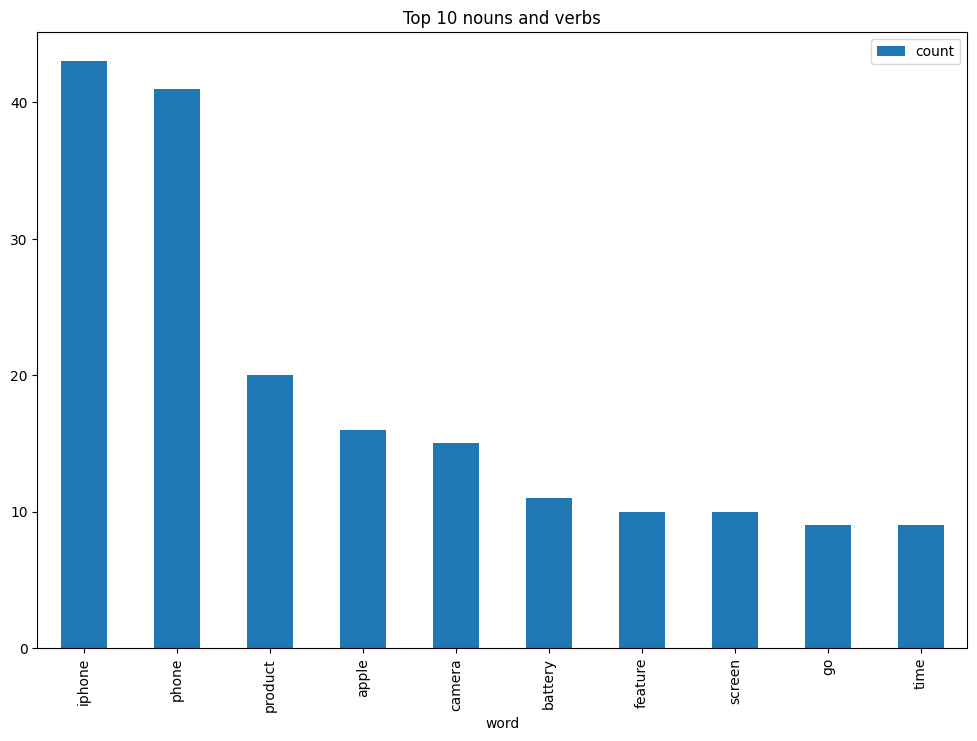

In [125]:
# Visualizing results (Barchart for top 10 nouns + verbs)
wd_df[0:10].plot.bar(x='word',figsize=(12,8),title='Top 10 nouns and verbs')

# **Feature Extraction**

Feature Extraction for 'Key Words'

In [126]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(dataframe['Clean_Reviews'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(dataframe['Clean_Reviews'])

# **Fetch sentiments**

To proceed further, we need to know the sentiment type of every tweet, that can be done using two ways:

**a.** **Using NLTK's SentimentIntensityAnalyzer (We'll refer as SIA)**

**b.** **Using TextBlob**

In [161]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

a. Using NLTK's SentimentIntensityAnalyzer

In [162]:
sentiments_using_SIA = dataframe.Clean_Reviews.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,Clean_Reviews
pos,94
neg,2


In [163]:
dataframe.Clean_Reviews[8]

'good product'

In [164]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(dataframe.Clean_Reviews[8])

{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'compound': 0.4404}

In [165]:
df=pd.DataFrame()
df['Review'] = dataframe.Clean_Reviews
df['scores'] = dataframe['Clean_Reviews'].apply(lambda review: sid.polarity_scores(review))
df.head()

,Review,scores
0,review side good know buying rather regretting...,"{'neg': 0.113, 'neu': 0.784, 'pos': 0.103, 'co..."
1,phoneapple phone without second delay would sa...,"{'neg': 0.027, 'neu': 0.681, 'pos': 0.292, 'co..."
2,liked phone,"{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp..."
3,pro powerful bionic chip beautiful oled displa...,"{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp..."
4,prefer privacy life think apple suite bit priv...,"{'neg': 0.139, 'neu': 0.671, 'pos': 0.191, 'co..."


In [166]:
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df.head()

,Review,scores,compound
0,review side good know buying rather regretting...,"{'neg': 0.113, 'neu': 0.784, 'pos': 0.103, 'co...",-0.0408
1,phoneapple phone without second delay would sa...,"{'neg': 0.027, 'neu': 0.681, 'pos': 0.292, 'co...",0.9969
2,liked phone,"{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp...",0.4215
3,pro powerful bionic chip beautiful oled displa...,"{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...",0.9678
4,prefer privacy life think apple suite bit priv...,"{'neg': 0.139, 'neu': 0.671, 'pos': 0.191, 'co...",0.7888


In [167]:
df['sentiment'] = df['compound'].apply(lambda c: 'Positive' if c >=0.05 else ('Negative' if c<=-0.05  else 'Neutral'))
df

,Review,scores,compound,sentiment
0,review side good know buying rather regretting...,"{'neg': 0.113, 'neu': 0.784, 'pos': 0.103, 'co...",-0.0408,Neutral
1,phoneapple phone without second delay would sa...,"{'neg': 0.027, 'neu': 0.681, 'pos': 0.292, 'co...",0.9969,Positive
2,liked phone,"{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp...",0.4215,Positive
3,pro powerful bionic chip beautiful oled displa...,"{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...",0.9678,Positive
4,prefer privacy life think apple suite bit priv...,"{'neg': 0.139, 'neu': 0.671, 'pos': 0.191, 'co...",0.7888,Positive
...,...,...,...,...
91,like camer,"{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'comp...",0.3612,Positive
92,premium device worth price great display excel...,"{'neg': 0.0, 'neu': 0.303, 'pos': 0.697, 'comp...",0.9300,Positive
93,best ipdone seriesproductivity good,"{'neg': 0.0, 'neu': 0.22, 'pos': 0.78, 'compou...",0.7964,Positive
94,good,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.4404,Positive


In [168]:
from collections import defaultdict
from plotly import tools
from plotly.offline import iplot
#Filtering data
positive_review = df[df["sentiment"]=='Positive'].dropna()
neutral_review = df[df["sentiment"]=='Neutral'].dropna()
negative_review = df[df["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram = 1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y =df["word"].values[::-1],
        x = df["wordcount"].values[::-1],
        showlegend = False,
        orientation = 'h',
        marker = dict(
            color = color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in positive_review["Review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'blue')


## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in neutral_review["Review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(20), 'purple')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in negative_review["Review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(20), 'yellow')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing = 0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

<Axes: xlabel='sentiment', ylabel='count'>

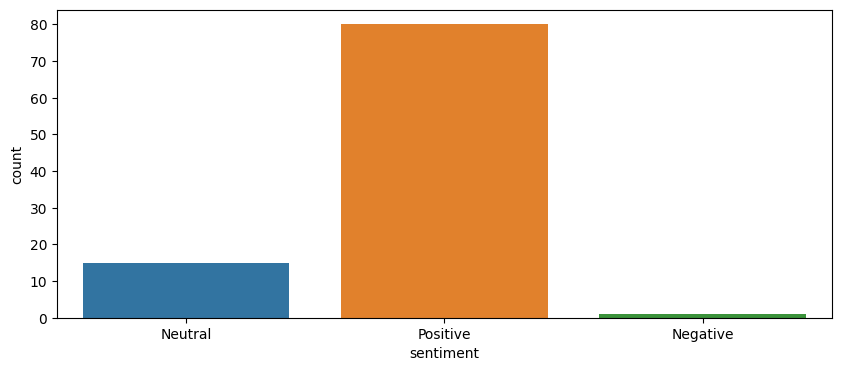

In [169]:
plt.figure(figsize=(10,4))
sns.countplot(x='sentiment',data=df)

<Axes: xlabel='compound', ylabel='Count'>

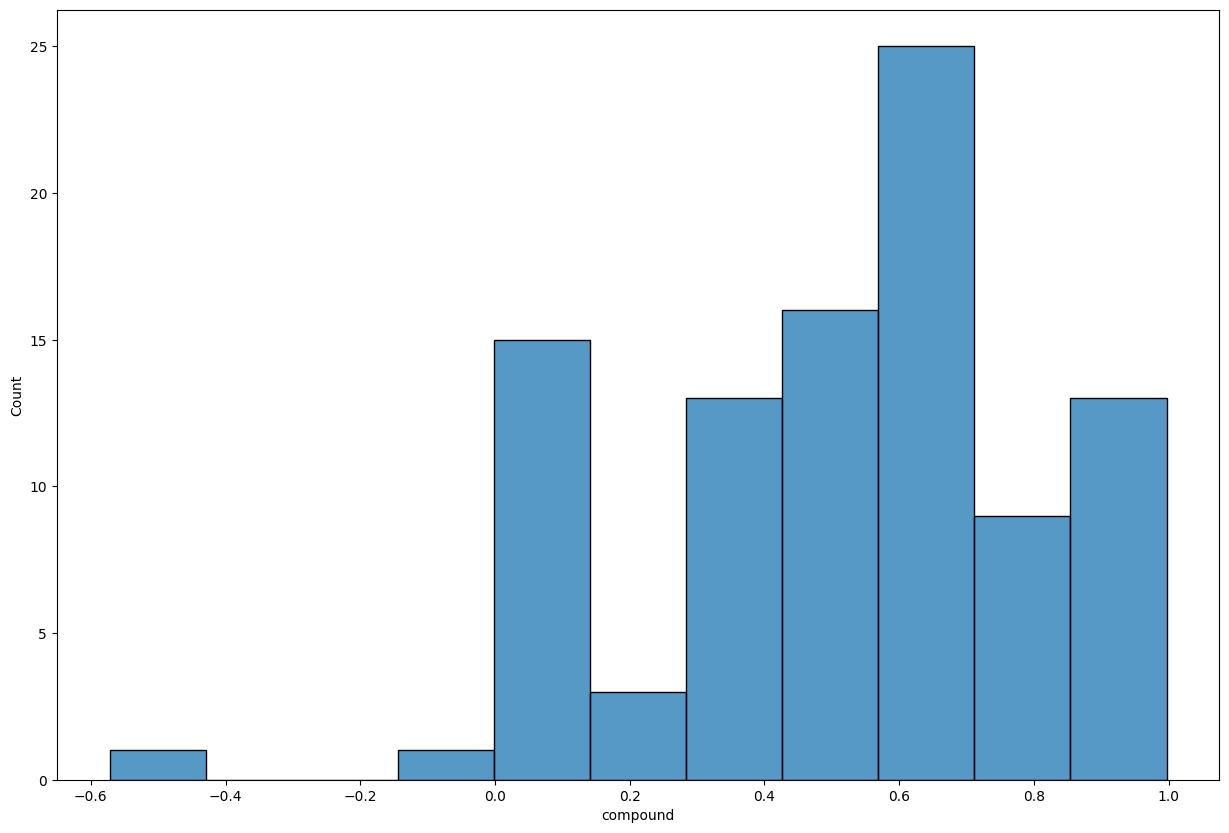

In [170]:
# Plotting the sentiment value for whole review
import seaborn as sns
plt.figure(figsize=(15,10))
sns.histplot(df['compound'])

In [171]:
# let's calculate subjectivity and Polarity
# function for subjectivity
def calc_subj(text):
    return TextBlob(text).sentiment.subjectivity

# function for Polarity
def calc_pola(text):
    return TextBlob(text).sentiment.polarity

dataframe['Subjectivity'] = dataframe.Clean_Reviews.apply(calc_subj)
dataframe['Polarity'] = dataframe.Clean_Reviews.apply(calc_pola)
dataframe.head()

,Clean_Reviews,Uncleaned_Reviews,Subjectivity,Polarity
0,review side good know buying rather regretting...,It is just a review from my side so that its g...,0.398422,0.144886
1,phoneapple phone without second delay would sa...,About the phoneApple phone without a second de...,0.408962,0.206098
2,liked phone,Very liked the phone,0.800000,0.600000
3,pro powerful bionic chip beautiful oled displa...,Pros:1. Powerful A15 Bionic chip2. Beautiful O...,0.627110,0.288312
4,prefer privacy life think apple suite bit priv...,"I prefer to have some privacy in life, I think...",0.364744,0.076923


Text(0, 0.5, 'Subjectivity')

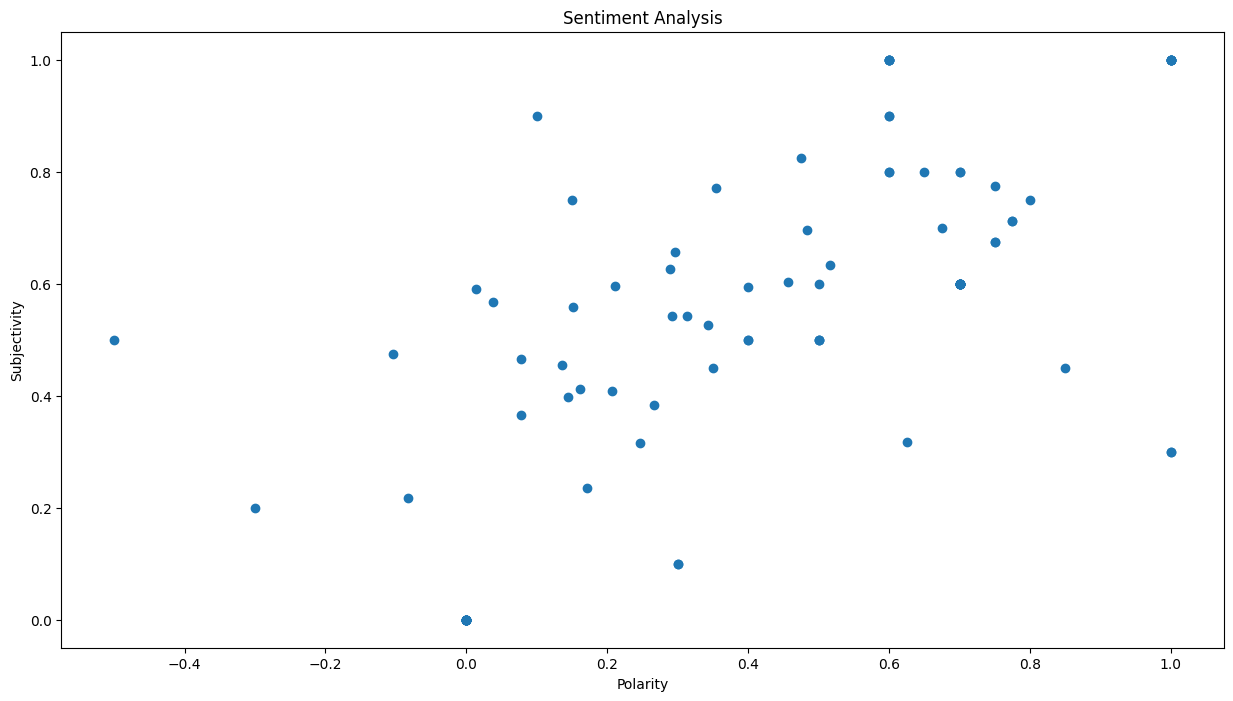

In [172]:
f, axes = plt.subplots(figsize = (15,8))
plt.scatter(dataframe.Polarity, dataframe.Subjectivity)
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

In [173]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")


type_ = ["Positive", "Neutral", "Negative"]
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Pie(labels=type_, values=df['sentiment'].value_counts(), name="sentiment"))

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Sentiment Analysis",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Sentiment', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

NLTK gives us more negative sentiments than TexBlob, so we will prefer NLTK, since classfication seems better.

# **Story Generation and Visualization**

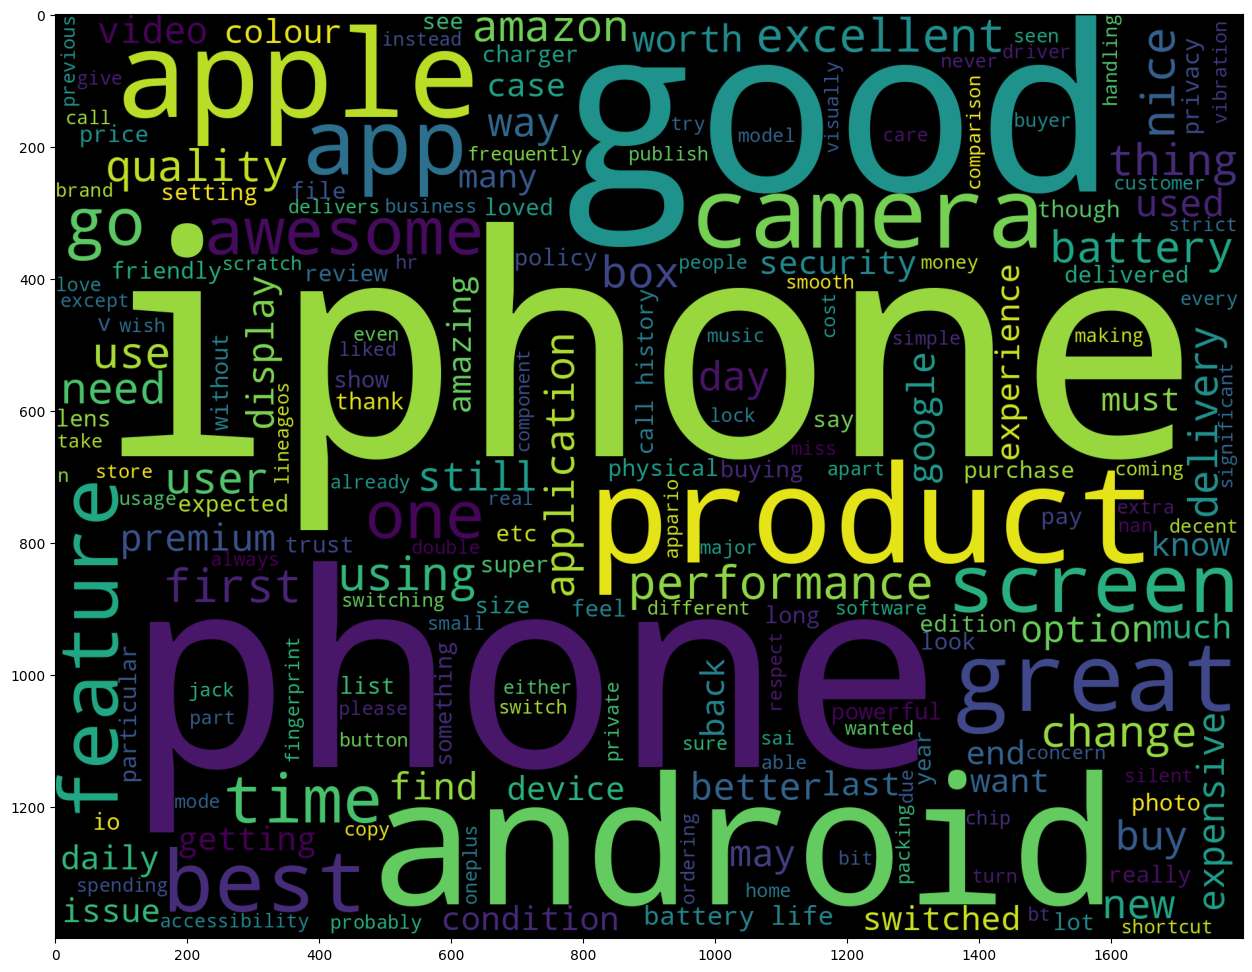

In [157]:
allWords_ = ' '.join([review for review in dataframe[:500]['Clean_Reviews']])
f, axes = plt.subplots(figsize=(20,12))
wordcloud= WordCloud(
        background_color = 'black',
        width = 1800,
        height =1400).generate(allWords_)
plt.imshow(wordcloud)